In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

100%|██████████| 66.0M/66.0M [00:00<00:00, 162MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# Load the dataset
dataset_path = path  # Path where KaggleHub downloaded the dataset
file = dataset_path + '/creditcard.csv'  # Adjust based on folder content

# Read the dataset
df = pd.read_csv(file)

print(f"Dataset loaded. Shape: {df.shape}")
df.head()


Dataset loaded. Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


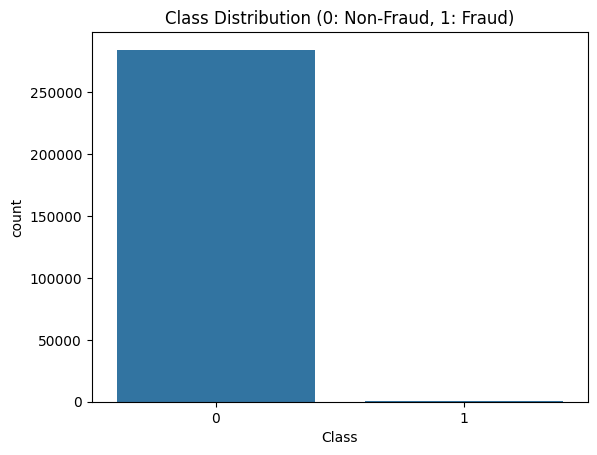

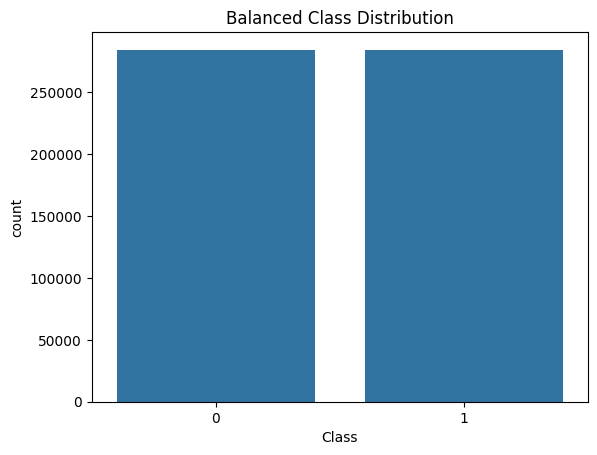

In [7]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Normalize 'Amount' column
scaler = MinMaxScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Drop 'Time' column (optional; it might not be relevant)
df = df.drop(['Time'], axis=1)

# Check class distribution
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0: Non-Fraud, 1: Fraud)")
plt.show()

# Handle class imbalance
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]

# Upsample the minority class (Fraud)
fraud_upsampled = resample(fraud,
                           replace=True,
                           n_samples=len(non_fraud),
                           random_state=42)

# Combine the balanced dataset
balanced_df = pd.concat([non_fraud, fraud_upsampled])
balanced_df = balanced_df.sample(frac=1, random_state=42)  # Shuffle

# Verify class distribution after balancing
sns.countplot(x='Class', data=balanced_df)
plt.title("Balanced Class Distribution")
plt.show()


In [8]:
# Define input and output
X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

# Reshape for RNN (samples, timesteps, features)
X = X.values.reshape(X.shape[0], 1, X.shape[1])

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (454904, 1, 29)
Testing Data Shape: (113726, 1, 29)


In [9]:
# Build the RNN (LSTM) model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 128)              │          80,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,417 (517.25 KB)

 Trainable params: 132,417 (517.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 92s 8ms/step - accuracy: 0.9743 - loss: 0.0683 - val_accuracy: 0.9979 - val_loss: 0.0084
Epoch 2/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 140s 8ms/step - accuracy: 0.9969 - loss: 0.0109 - val_accuracy: 0.9986 - val_loss: 0.0064
Epoch 3/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 139s 7ms/step - accuracy: 0.9984 - loss: 0.0065 - val_accuracy: 0.9987 - val_loss: 0.0052
Epoch 4/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 141s 7ms/step - accuracy: 0.9989 - loss: 0.0048 - val_accuracy: 0.9994 - val_loss: 0.0029
Epoch 5/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - accuracy: 0.9991 - loss: 0.0036 - val_accuracy: 0.9994 - val_loss: 0.0032
Epoch 6/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 89s 8ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9994 - val_loss: 0.0033
Epoch 7/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 141s 8ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9983 - val_loss: 0.0098


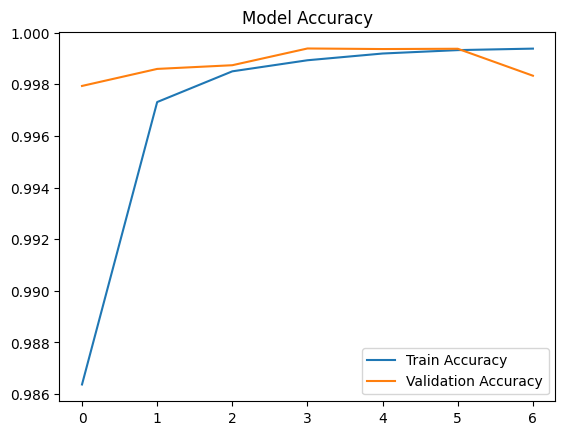

In [10]:
# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()


3554/3554 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Confusion Matrix:


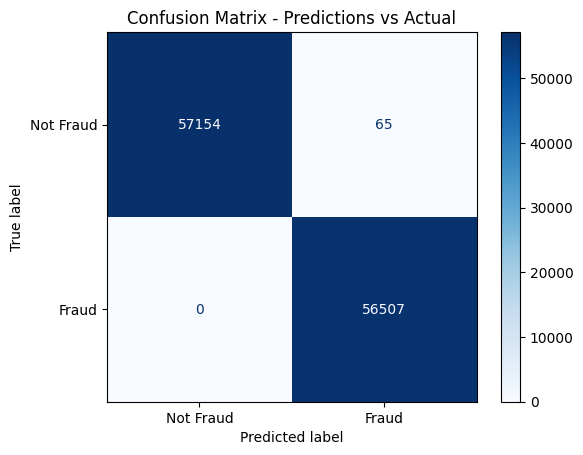


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57219
           1       1.00      1.00      1.00     56507

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



In [11]:
# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix and Classification Report
print("Confusion Matrix:")


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])

# Display confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Predictions vs Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

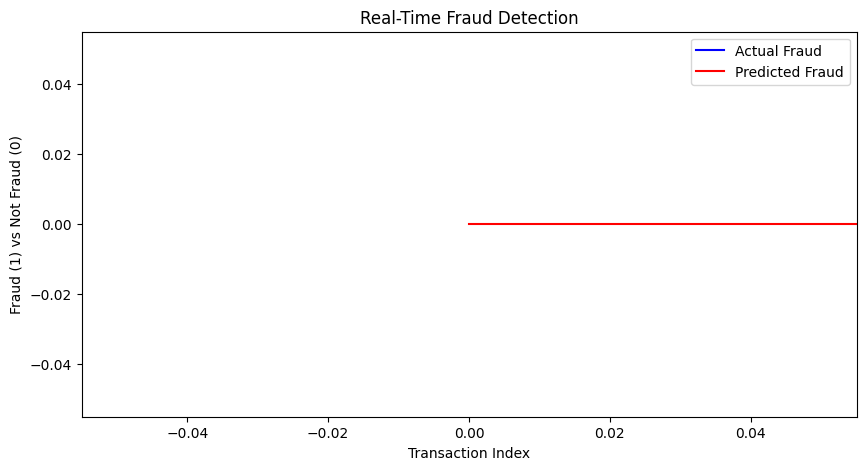

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Sample data (replace with your actual data)
y_test = np.random.randint(0, 2, size=(100,))
y_pred = np.random.randint(0, 2, size=(100,))

def update_plot(frame, true_labels, pred_labels, ax, line_actual, line_predicted):
    # Update the lines for actual and predicted
    line_actual.set_data(np.arange(frame), true_labels[:frame])
    line_predicted.set_data(np.arange(frame), pred_labels[:frame])
    return line_actual, line_predicted

# Real-time fraud detection prediction visualization
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Real-Time Fraud Detection")
ax.set_xlabel("Transaction Index")
ax.set_ylabel("Fraud (1) vs Not Fraud (0)")

line_actual, = ax.plot([], [], label='Actual Fraud', color='blue')
line_predicted, = ax.plot([], [], label='Predicted Fraud', color='red')
ax.legend()

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, fargs=(y_test, y_pred, ax, line_actual, line_predicted),
                              frames=len(y_test), interval=100, blit=True)

# Display animation in Google Colab
HTML(ani.to_jshtml())
